In [1]:
import numpy as np
import matplotlib.pyplot as pl

In [41]:
def radial_profile(data: np.ndarray, centre: tuple):
    """_summary_

    Parameters
    ----------
    data : np.ndarray
        _description_
    centre : tuple
        _description_

    Returns
    -------
    _type_
        _description_
    """
    
    x, y = np.indices((data.shape))
    r = np.sqrt((x - centre[0]) ** 2 + (y - centre[1]) ** 2)
    r = r.astype(int)
    
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

In [72]:
#read in data
from ddm.data_handling import readLIF
dData = readLIF('../tests/data/testData1series.lif')

AttributeError: 'BioformatsReader' object has no attribute 'shape'

In [ ]:
#dummy data for testing
dData = np.random.randint(0, 256, size = (20, 512, 512))

In [65]:
#method 1 - high q for A = 0 - rework to optimise the FFTs???
def fitABhighQ(dumData):
    sqFFT = 2*np.abs(np.fft.fft2(dumData)**2)
    sqFFT = np.fft.fftshift(sqFFT)
    sqFFTmean = np.mean(sqFFT, axis = 0)
    sqFFTrad = radial_profile(sqFFTmean, (np.shape(dumData)[0]/2, np.shape(dumData)[1]/2))
    b = np.mean(sqFFTrad[-100:-50]) #change depending on size of array
    a = sqFFTrad - b
    return a, b

In [66]:
print(type(dData))
A, B = fitABhighQ(dData)

<class 'xarray.core.dataarray.DataArray'>
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)


(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)


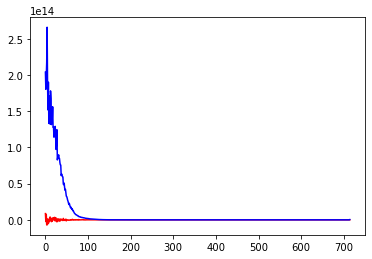

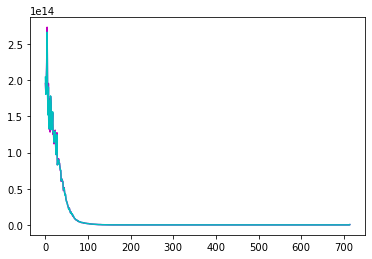

In [32]:
#method 2 - delay time is zero then A = real part of squared stuff
fTFt = np.fft.fftshift(2*np.fft.fft2(dData)*np.conj(np.fft.fft2(dData, axes = (0,1))))
aFull = np.real(np.mean(fTFt, axis = 0))
c = radial_profile(aFull, (512, 512))
pl.figure(0)
pl.plot(c[10:], color = 'r')
pl.plot(A[10:], color = 'b')

SqFFT = 2*np.abs(np.fft.fft2(dData)**2)
SqFFT = np.fft.fftshift(SqFFT)
SqFFTmean = np.mean(SqFFT, axis = 0)
SqFFTrad = radial_profile(SqFFTmean, (512, 512))

d = SqFFTrad - c

pl.figure(1)
pl.plot(d[10:], color = 'm')
pl.plot(sqFFTrad[10:], color = 'c')

In [13]:
from ddm.processing import ddm

In [40]:
result = np.array([None for i in range(10)])
for delay in range(10):
    result[delay] = ddm(dData, delay).compute()

(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)


Text(0.5, 0, 'tau')

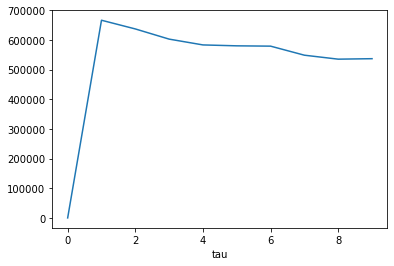

In [71]:
result2 = np.dstack(result)[0]

q = 200

f = 1.-(result2[q]-B)/A[q]

pl.figure(2)
pl.plot(f)
pl.xlabel('tau')